## Problem3

In [1]:
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

In [2]:
# Imports.
import random
import network.network as Network
import network.mnist_loader as mnist_loader
import pickle
import matplotlib.pyplot as plt

# Set the random seed. DO NOT CHANGE THIS!
seedVal = 41
random.seed(seedVal)
np.random.seed(seedVal)

%matplotlib inline

Use a pre-trained network. It has been saved as a pickle file. Load the model, and continue.
The network has only one hidden layer of 30 units, 784 input units (MNIST images are $ 28 \times 28 = 784 $ pixels large), and 10 output units. All the activations are sigmoidal.

In [3]:
# Load the pre-trained model.
with open('network/trained_network.pkl', 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    net = u.load()

# Helpful function to load the MNIST data.
training_data, validation_data, test_data = mnist_loader.load_data_wrapper()

The neural network is pretrained, so it should already be set up to predict characters. Run `predict(n)` to evaluate the $ n^{th} $ digit in the test set using the network. You should see that even this relatively simple network works really well (~97% accuracy). The output of the network is a one-hot vector indicating the network's predictions:

Network output: 
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]]

Network prediction: 8

Actual image: 


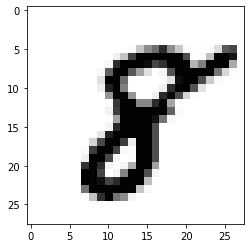

In [4]:
def predict(n):
    # Get the data from the test set
    x = test_data[n][0]
    
    # Print the prediction of the network
    print('Network output: \n' + str(np.round(net.feedforward(x), 2)) + '\n')
    print('Network prediction: ' + str(np.argmax(net.feedforward(x))) + '\n')
    print('Actual image: ')
    
    # Draw the image
    plt.imshow(x.reshape((28,28)), cmap='Greys')

# Replace the argument with any number between 0 and 9999
predict(8384)

To actually generate adversarial examples we solve a minimization problem. We do this by setting a "goal" label called $ \vec y_{goal} $ (for instance, if we wanted the network to think the adversarial image is an 8, then we would choose $ \vec y_{goal} $ to be a one-hot vector with the eighth entry being 1). Now we define a cost function:

$$ C = \frac{1}{2} \|\vec y_{goal} - \hat y(\vec x)\|^2_2 $$

where $ \| \cdot \|^2_2 $ is the squared Euclidean norm and $ \hat y $ is the network's output. It is a function of $ \vec x $, the input image to the network, so we write $ \hat y(\vec x) $. Our goal is to find an $ \vec x $ such that $ C $ is minimized. Hopefully this makes sense, because if we find an image $ \vec x $ that minimizes $ C $ then that means the output of the network when given $ \vec x $ is close to our desired output, $ \vec y_{goal} $. So in full mathy language, our optimization problem is:

$$ \arg \min_{\vec x} C(\vec x) $$

that is, find the $ \vec x $ that minimizes the cost $ C $.

To actually do this we can do gradient descent on $ C $. Start with an initially random vector $ \vec x $ and take steps (changing $ \vec x $) gradually in the direction opposite of the gradient $ \nabla_x C $. To actually get these derivatives we can perform backpropagation on the network. In contrast to training a network, where we perform gradient descent on the weights and biases, when we create adversarial examples we hold the weights and biases constant (because we don't want to change the network!), and change the inputs to our network.

Helper functions to evaluate the non-linearity and it's derivative:

In [6]:
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))
                                                                                                                                                                                
def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))

Also, a function to find the gradient derivatives of the cost function, $ \nabla_x C $ with respect to the input $ \vec x $, with a goal label of $ \vec y_{goal} $. (Don't worry too much about the implementation, just know it calculates derivatives).

In [7]:
def input_derivative(net, x, y):
    """ Calculate derivatives wrt the inputs"""
    nabla_b = [np.zeros(b.shape) for b in net.biases]
    nabla_w = [np.zeros(w.shape) for w in net.weights]
    
    # feedforward
    activation = x
    activations = [x] # list to store all the activations, layer by layer
    zs = [] # list to store all the z vectors, layer by layer
    for b, w in zip(net.biases, net.weights):
        z = np.dot(w, activation)+b
        zs.append(z)
        activation = sigmoid(z)
        activations.append(activation)
        
    # backward pass
    delta = net.cost_derivative(activations[-1], y) * \
        sigmoid_prime(zs[-1])
    nabla_b[-1] = delta
    nabla_w[-1] = np.dot(delta, activations[-2].transpose())

    for l in range(2, net.num_layers):
        z = zs[-l]
        sp = sigmoid_prime(z)
        delta = np.dot(net.weights[-l+1].transpose(), delta) * sp
        nabla_b[-l] = delta
        nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        
    # Return derivatives WRT to input
    return net.weights[0].T.dot(delta)

The actual function that generates adversarial examples and a wrapper function:

## (a) Non Targeted Attack

In [8]:
def nonTargetedAdversarial(net, n, steps, eta):
    """
    net : network object
        neural network instance to use
    n : integer
        our goal label (just an int, the function transforms it into a one-hot vector)
    steps : integer
        number of steps for gradient descent
    eta : float
        step size for gradient descent
    """
    
    ####### Enter your code below #######
    
    # Set the goal output
    goal = np.zeros((10,1))
    goal[n] = 1

    # Create a random image to initialize gradient descent with
    x = np.random.normal(.5, .3, (784, 1))
    
    # Gradient descent on the input
    for i in range(steps):
        # Calculate the derivative
        d = input_derivative(net,x,goal)
    
        # The GD update on x
        x -= eta*d;
            
    return x


# Wrapper function 
def generate(n):
    """
    n : integer
        goal label (not a one hot vector)
    """
    
    ####### Enter your code below #######
    
    # Find the vector x with the above function that you just wrote.
    a=nonTargetedAdversarial(net,n,1000,0.01)
    
    # Pass the generated image (vector) to the neural network. Perform a forward pass, and get the prediction.
    x = net.feedforward(a)
    
    print('Network Output: \n' + str(np.round(x,2)) + '\n')
    
    print('Network Prediction: ' + str(np.argmax(x)) + '\n')
    
    print('Adversarial Example: ')
    
    plt.imshow(a.reshape(28,28), cmap='Greys')

Now let's generate some adversarial examples! Use the function provided to mess around with the neural network. (For some inputs gradient descent doesn't always converge; 0 and 5 seem to work pretty well though. I suspect convergence is very highly dependent on our choice of random initial $ \vec x $. We'll see later in the notebook if we force the adversarial example to "look like" a handwritten digit, convergence is much more likely. In a sense we will be adding regularization to our generation process).

Network Output: 
[[0.  ]
 [0.  ]
 [0.95]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]]

Network Prediction: 2

Adversarial Example: 


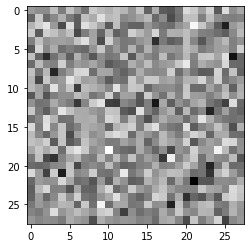

In [9]:
generate(2)

## (b) Targeted Attack(s)

Sweet! We've just managed to create an image that looks utterly meaningless to a human, but the neural network thinks is a '5' with very high certainty. We can actually take this a bit further. Let's generate an image that looks like one number, but the neural network is certain is another. To do this we will modify our cost function a bit. Instead of just optimizing the input image, $ \vec x $, to get a desired output label, we'll also optimize the input to look like a certain image, $ \vec x_{target} $, at the same time. Our new cost function will be

$$ C = \|\vec y_{goal} - y_{hat}(\vec x)\|^2_2 + \lambda \|\vec x - \vec x_{target}\|^2_2 $$

The added term tells us the distance from our $ \vec x $ and some $ \vec x_{target} $ (which is the image we want our adversarial example to look like). Because we want to minimize $ C $, we also want to minimize the distance between our adversarial example and this image. The $ \lambda $ is hyperparameter that we can tune; it determines which is more important: optimizing for the desired output or optimizing for an image that looks like $ \vec x_{target} $.

If you are familiar with ridge regularization, the above cost function might look suspiciously like the ridge regression cost function. In fact, we can view this generation method as giving our model a prior, centered on our target image.

Here is a function that implements optimizing the modified cost function, called `sneaky_adversarial` (because it is very sneaky). Note that the only difference between this function and `adversarial` is an additional term on the gradient descent update for the regularization term:

In [10]:
def targetedAdversarial(net, n, x_target, steps, eta, lam=.05):
    """
    net : network object
        neural network instance to use
    n : integer
        our goal label (just an int, the function transforms it into a one-hot vector)
    x_target : numpy vector
        our goal image for the adversarial example
    steps : integer
        number of steps for gradient descent
    eta : float
        step size for gradient descent
    lam : float
        lambda, our regularization parameter. Default is .05
    """
    
    # Set the goal output
    goal = np.zeros((10, 1))
    goal[n] = 1
    
    # Create a random image to initialize gradient descent with
    x = np.random.normal(.5, .3, (784, 1))

    # Gradient descent on the input
    for i in range(steps):
        
        # Calculate the derivative
        d = input_derivative(net,x,goal)
        
        # The GD update on x, with an added penalty to the cost function
        x -= eta*(d + lam*(x-x_target))

    return x

# Wrapper function
def generate_advSample(n, m):
    """
    n: int 0-9, the target number to match
    m: index of example image to use (from the test set)
    """
    
    # Find random instance of m in test set
    idx = np.random.randint(0,8000)
    while test_data[idx][1] != m:
        idx += 1
    
    # Hardcode the parameters for the wrapper function
    a = targetedAdversarial(net, n, test_data[idx][0], 100, 1)
    x = np.round(net.feedforward(a), 2)
    
    print('\nWhat we want our adversarial example to look like: ')
    plt.imshow(test_data[idx][0].reshape((28,28)), cmap='Greys')
    plt.show()
    
    print('\n')
    
    print('Adversarial Example: ')
    
    plt.imshow(a.reshape(28,28), cmap='Greys')
    plt.show()
    
    print('Network Prediction: ' + str(np.argmax(x)) + '\n')
    
    print('Network Output: \n' + str(x) + '\n')
    
    return a

Play around with this function to make "sneaky" adversarial examples! (Again, some numbers converge better than others... try 0, 2, 3, 5, 6, or 8 as a target label. 1, 4, 7, and 9 still don't work as well... no idea why... We get more numbers that converge because we've added regularization term to our cost function. Perhaps changing $ \lambda $ will get more to converge?)


What we want our adversarial example to look like: 


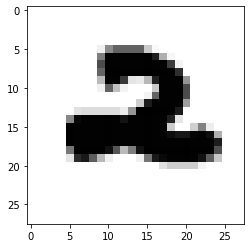



Adversarial Example: 


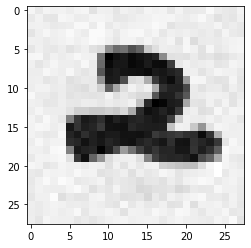

Network Prediction: 8

Network Output: 
[[0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.99]
 [0.  ]]



In [11]:
# generate_advSample(target label, target digit)
adv_ex = generate_advSample(8, 2)

## (c) Protection against adversarial attacks

Awesome! We’ve just created images that trick neural networks. The next question we could ask is whether or not we could protect against these kinds of attacks. If you look closely at the original images and the adversarial examples you’ll see that the adversarial examples have some sort of grey tinged background.

So how could we protect against these adversarial attacks? One very simple way would be to use binary thresholding. Set a pixel as completely black or completely white depending on a threshold. This should remove the "noise" that's always present in the adversarial images. Let's see if it works:

In [12]:
def simple_defense(n, m):
    """
    n: int 0-9, the target number to match
    m: index of example image to use (from the test set)
    """
    
    # Generate an adversarial sample.
    x = generate_advSample(n, m)
    
    # Perform binary thresholding on the generated sample. You can choose the threshold as 0.5.
    x = (x > .5).astype(float)
    print("With binary thresholding: ")
    
    # Plot a grayscale image of the binarized generated sample.
    plt.imshow(x.reshape(28,28), cmap="Greys")
    plt.show()
    
    binary_activations = net.feedforward(x)
    binary_prediction = np.argmax(net.feedforward(x))

    # Print the network's predictions.
    print("Prediction with binary thresholding: " + str(binary_prediction) + '\n')
    
    # The output of the network.
    print("Network output: ")
    print( str(np.round(binary_activations,2)) )


What we want our adversarial example to look like: 


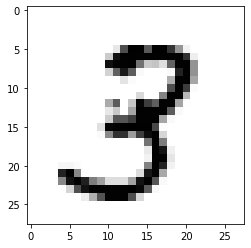



Adversarial Example: 


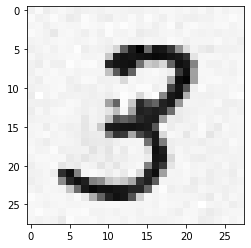

Network Prediction: 2

Network Output: 
[[0.  ]
 [0.  ]
 [0.95]
 [0.03]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]]

With binary thresholding: 


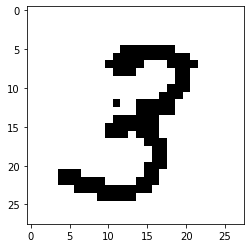

Prediction with binary thresholding: 3

Network output: 
[[0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


In [13]:
# binary_thresholding(target digit, actual digit)
simple_defense(2, 3)

Looks like it works pretty well! However, note that most adversarial attacks, especially on convolutional neural networks trained on massive full color image sets such as imagenet, can't be defended against by a simple binary threshold.

## Adversarial Training

Looks like it works pretty well! However, note that most adversarial attacks, especially on convolutional neural networks trained on massive full color image sets such as imagenet, can't be defended against by a simple binary threshold.

We could try one more thing that might be a bit more universal to protect our neural network against adversarial attacks. If we had access to the adversarial attack method (which we do in this case, because we're the ones implementing the attack) we could create a ton of adversarial examples, mix that up with our training dataset with the correct labels, and then retrain a network on this augmented dataset. The retrained network should learn to ignore the adversarial attacks. Here we implement a function to do just that.

In [14]:
def augment_data(n, data, steps):
    """
    n : integer
        number of adversarial examples to generate
    data : list of tuples
        data set to generate adversarial examples using
    """
    # Our augmented training set:
    augmented = []
    
    for i in range(n):
        # Progress "bar"
        if i % 500 == 0:
            print("Generated digits: " + str(i))
            
        # Randomly choose a digit that the example will look like
        rnd_actual_digit = random.randint(0,9)
         
        # Find random instance of rnd_actual_digit in the training set
        rnd_actual_idx = np.random.randint(0,8000)
        
        # TODO : Find a random instance of rnd_actual_digit in the training set. 
        while True:
            arr = data[rnd_actual_idx][1]
            dig_val = arr.squeeze().tolist().index(1)
            if(dig_val == rnd_actual_digit):
                break
            rnd_actual_idx += 1
        x_target = data[rnd_actual_idx][0]
        y_actual = data[rnd_actual_idx][1]
            
        true_digit_label = y_actual.squeeze().tolist().index(1)
        
        # Choose a value for the adversarial attack
        while True:
            rnd_fake_digit = np.random.randint(10)
            if rnd_fake_digit != true_digit_label: break
    
        # Generate adversarial example
        x_adversarial = targetedAdversarial(net, rnd_fake_digit, x_target, steps, 1)
        x_adversarial = np.array((x_adversarial, y_actual))
        # Add new data       
        augmented.append(x_adversarial)
        
    return augmented

In [15]:
# Try 10000 examples first if you don't want to wait for a long time!
augmented = augment_data(10000, training_data, 100)

Generated digits: 0
Generated digits: 500
Generated digits: 1000
Generated digits: 1500
Generated digits: 2000
Generated digits: 2500
Generated digits: 3000
Generated digits: 3500
Generated digits: 4000
Generated digits: 4500
Generated digits: 5000
Generated digits: 5500
Generated digits: 6000
Generated digits: 6500
Generated digits: 7000
Generated digits: 7500
Generated digits: 8000
Generated digits: 8500
Generated digits: 9000
Generated digits: 9500


Now let's check to make sure our augmented dataset actually makes sense. Here we have a function that checks the $ i^{th} $ example in our augmented set.

Image: 



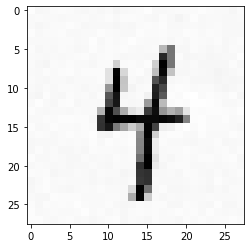

Original network prediction: 

[[0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.98]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]]

Label: 

[[0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


In [16]:
def check_augmented(i, augmented):
    # Show image
    print('Image: \n')
    plt.imshow(augmented[i][0].reshape(28,28), cmap='Greys')
    plt.show()
    
    # Show original network prediction
    print('Original network prediction: \n')
    print(np.round(net.feedforward(augmented[i][0]), 2))
    
    # Show label
    print('\nLabel: \n')
    print(augmented[i][1])
    
# check i^th adversarial image
check_augmented(239, augmented)

We can now create a new neural network and train it on our augmented dataset and the original training set, using the original test set to validate.

In [17]:
# Create a new network. Use the function provided in the Network.network to create one. For this you'll have to 
# read the description of the function there. 
net2 = Network.Network([784,1])

# Train on the augmented + original training set
combined_train_data = []
for j in augmented:
    combined_train_data.append(j)
for j in training_data:
    combined_train_data.append(j)
random.shuffle(combined_train_data)
net2.SGD(combined_train_data, epochs=100, mini_batch_size=5, eta=1,
            test_data=test_data)

Epoch 0: 6992 / 10000
Epoch 1: 7450 / 10000
Epoch 2: 7511 / 10000
Epoch 3: 7543 / 10000
Epoch 4: 7553 / 10000
Epoch 5: 7549 / 10000
Epoch 6: 7563 / 10000
Epoch 7: 7541 / 10000
Epoch 8: 7575 / 10000
Epoch 9: 7583 / 10000
Epoch 10: 7571 / 10000
Epoch 11: 7573 / 10000
Epoch 12: 7587 / 10000
Epoch 13: 8262 / 10000
Epoch 14: 8312 / 10000
Epoch 15: 8379 / 10000
Epoch 16: 8365 / 10000
Epoch 17: 8367 / 10000
Epoch 18: 8361 / 10000
Epoch 19: 8355 / 10000
Epoch 20: 8342 / 10000
Epoch 21: 8359 / 10000
Epoch 22: 8353 / 10000
Epoch 23: 8363 / 10000
Epoch 24: 8357 / 10000
Epoch 25: 8364 / 10000
Epoch 26: 8352 / 10000
Epoch 27: 8357 / 10000
Epoch 28: 8353 / 10000
Epoch 29: 8364 / 10000
Epoch 30: 8365 / 10000
Epoch 31: 8372 / 10000
Epoch 32: 8361 / 10000
Epoch 33: 8366 / 10000
Epoch 34: 8378 / 10000
Epoch 35: 8376 / 10000
Epoch 36: 8368 / 10000
Epoch 37: 8380 / 10000
Epoch 38: 8349 / 10000
Epoch 39: 8368 / 10000
Epoch 40: 8350 / 10000
Epoch 41: 8382 / 10000
Epoch 42: 8355 / 10000
Epoch 43: 8368 / 1000

With a network trained on 50000 adversarial examples in addition to 50000 original training set examples we get about 95% accuracy (it takes quite a long time as well). We can make a test set of adversarial examples by using the following function call:

In [18]:
# For some reason the training data has the format: list of tuples
# tuple[0] is np array of image
# tuple[1] is one hot np array of label
# test data is also list of tuples
# tuple[0] is np array of image
# tuple[1] is integer of label
# Just fixing this:
normal_test_data = []

for i in range(len(test_data)):
    ground_truth = test_data[i][1]
    one_hot = np.zeros(10)
    one_hot[ground_truth] = 1
    one_hot = np.expand_dims(one_hot, axis=1)
    normal_test_data.append((test_data[i][0], one_hot))
    

# Using normal_test_data because of weird way data is packaged
adversarial_test_set = augment_data(1000, normal_test_data, 100)

Generated digits: 0
Generated digits: 500


Let's checkout the accuracy of our newly trained network on adversarial examples from the new adversarial test set:

In [19]:
def accuracy(net, test_data):
    """
    net : network object
    test_data: list
        list of 2-tuples of two arrays, one image and one label (one-hot)
    """
    tot = float(len(test_data))
    correct = 0
    for i in range(len(test_data)):
        dt = test_data[i]
        pred = np.argmax(net.feedforward(dt[0]))
        tr_label = dt[1].squeeze().tolist().index(1)
        if(pred==tr_label):
            correct += 1
    
    return correct / tot

print('Accuracy of the new augmented model on the adversarial test set: ' + str(accuracy(net2, adversarial_test_set)))
print('Accuracy of the new augmented model on the original test set: ' + str(accuracy(net2, normal_test_data)))

print('Accuracy of the original network on the adversarial test set: ' + str(accuracy(net, adversarial_test_set)))
print('Accuracy of the original network on the original test set: ' + str(accuracy(net, normal_test_data)))

Accuracy of the new augmented model on the adversarial test set: 0.836
Accuracy of the new augmented model on the original test set: 0.8348
Accuracy of the original network on the adversarial test set: 0.45
Accuracy of the original network on the original test set: 0.8701


Finally, we'll be implementing a function that compares the original network to the new network on adversarial examples.

In [20]:
# You'll be implementing a function that compares the original network to the new network. The specifications of 
# what this function has to achieve has been provided in the pdf.

# TODO : Implement a function.
def compare(original_net, new_net, adv_example):
    # Show image
    print('Image: \n')
    plt.imshow(adv_example[0].reshape(28,28), cmap='Greys')
    plt.show()
    
    # Show original network prediction
    print('Original network prediction: \n')
    print(np.round(original_net.feedforward(adv_example[0]), 2))

    # Show new network prediction
    print('New network prediction: \n')
    print(np.round(new_net.feedforward(adv_example[0]), 2))
    
    # Show label
    print('\nLabel: \n')
    print(adv_example[1])

Image: 



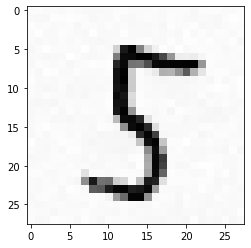

Original network prediction: 

[[0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.02]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]]
New network prediction: 

[[0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [1.  ]
 [0.  ]
 [0.  ]
 [0.01]
 [0.  ]]

Label: 

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]]


In [21]:
compare(net, net2, augmented[150])

Image: 



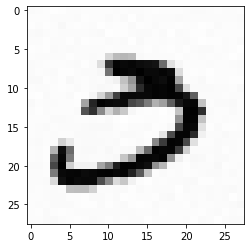

Original network prediction: 

[[0.  ]
 [0.  ]
 [0.  ]
 [0.02]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]]
New network prediction: 

[[0.  ]
 [0.  ]
 [0.  ]
 [1.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.01]
 [0.  ]
 [0.  ]]

Label: 

[[0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


In [22]:
compare(net, net2, augmented[850])

## Extra Credit

In [24]:
from art.estimators.classification import KerasClassifier
import scipy.stats as jslib
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
import keras
from keras.datasets import mnist
from keras import backend as K

## Function to Calculate Different Utility Metrics

### Imported Utility Function From DEEPSEC Repository

In [25]:
# calculate robustness of defense using utility metrics
def defense_utility_measure(pred_def, pred_raw, true_label):
    # compute the classification accuracy of raw model
    correct_prediction_raw = np.equal(np.argmax(pred_raw, axis=1), true_label)
    acc_raw = np.mean(correct_prediction_raw.astype(float))
    print("accuracy of raw model ", acc_raw)

    # compute the classification accuracy of defense-enhanced model
    correct_prediction_def = np.equal(np.argmax(pred_def, axis=1), true_label)
    acc_def = np.mean(correct_prediction_def.astype(float))
    print("accuracy of defense-enhanced model ",acc_def)

    # compute the Classification Accuracy Variance(CAV)
    cav_result = acc_def - acc_raw
    print("Classification Accuracy Variance (CAV)",cav_result)

    # find the index of correct predicted examples by defence-enhanced model and raw model
    idx_def = np.squeeze(np.argwhere(correct_prediction_def == True))
    idx_raw = np.squeeze(np.argwhere(correct_prediction_raw == True))
    idx = np.intersect1d(idx_def, idx_raw, assume_unique=True)

    # compute the Classification Rectify Ratio(CRR) & Classification Sacrifice Ratio(CSR)
    num_rectify = len(idx_def) - len(idx)
    crr_result = num_rectify / len(pred_def)
    print("Classification Rectify Ratio (CRR)",crr_result)

    num_sacrifice = len(idx_raw) - len(idx)
    csr_result = num_sacrifice / len(pred_def)
    
    print("Classification Sacrifice Ratio (CSR)", csr_result)

    # filter the correct prediction results
    pred_def_filter = pred_def[idx]
    pred_raw_filter = pred_raw[idx]

    # compute the Classification Confidence Variance(CCV)
    confidence_def = np.max(pred_def_filter, axis=1)
    confidence_raw = np.max(pred_raw_filter, axis=1)
    ccv_result = np.mean(np.absolute(confidence_def - confidence_raw))
    print("Classification Confidence Variance(CCV)", ccv_result)

    # compute the Classification Output Stability(COS)
    M = (pred_def_filter + pred_raw_filter) / 2.
    js_total = 0
    for i in range(len(M)):
        js = 0.5 * jslib.entropy(pred_def_filter[i], M[i]) + 0.5 * jslib.entropy(pred_raw_filter[i], M[i])
        js_total += js
    cos_result = js_total / len(M)
    print("Classification Output Stability (COS)", cos_result)

    #return acc_raw, acc_def, cav_result, crr_result, csr_result, ccv_result, cos_result

In [26]:
from keras.layers import Dense, Dropout, Flatten, InputLayer
from art.defences.preprocessor import Preprocessor
from art.defences.detector.evasion import BinaryInputDetector
from art.defences.preprocessor import SpatialSmoothing,FeatureSqueezing

In [27]:
## Collecting the training data from actual training data
final_train_x =  np.array( [seq[0] for seq in training_data] )
final_train_y =  np.array( [seq[1] for seq in training_data] )

## Using the previously generated adversarial_test_set for test
final_test_x = np.array( [seq[0] for seq in adversarial_test_set] )
final_test_y = np.array( [seq[1] for seq in adversarial_test_set] )

In [28]:
lb_y=[]
for j in range(len((final_train_y))):
    lb_y.append(np.argmax(final_train_y[j]))
final_train_y = np.array(lb_y)

final_train_x = final_train_x.reshape(final_train_x.shape[0], 1, 28, 28)
final_test_x = final_test_x.reshape(final_test_x.shape[0], 1, 28, 28)

true_label=[]
for j in range(len((final_test_y))):
    true_label.append(np.argmax(final_test_y[j]))
true_label = np.array(true_label) # true labels for adversarial test set

In [29]:
ann_based_model = Sequential()
ann_based_model.add(InputLayer(input_shape=(1,28,28)))

# Define the intermediate layers.

ann_based_model.add(Flatten())
ann_based_model.add(Dense(512, activation="relu"))
ann_based_model.add(Dense(256, activation="relu"))
ann_based_model.add(Dense(128, activation="relu"))
ann_based_model.add(Dense(64, activation="relu"))
ann_based_model.add(Dense(10, activation="softmax"))

# Compile the ANN model. 
ann_based_model.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=['acc'])
ann_based_classifier = KerasClassifier(model=ann_based_model, clip_values=(0,1))
ann_based_classifier.fit(final_train_x, final_train_y, nb_epochs=10, batch_size=32)


Epoch 1/10
50000/50000 [==============================] - 15s 307us/step - loss: 0.2272 - acc: 0.9299
Epoch 2/10
50000/50000 [==============================] - 15s 294us/step - loss: 0.1024 - acc: 0.9698
Epoch 3/10
50000/50000 [==============================] - 15s 310us/step - loss: 0.0700 - acc: 0.9786
Epoch 4/10
50000/50000 [==============================] - 16s 322us/step - loss: 0.0559 - acc: 0.9833
Epoch 5/10
50000/50000 [==============================] - 17s 338us/step - loss: 0.0442 - acc: 0.9859
Epoch 6/10
50000/50000 [==============================] - 19s 381us/step - loss: 0.0375 - acc: 0.9885
Epoch 7/10
50000/50000 [==============================] - 17s 338us/step - loss: 0.0313 - acc: 0.9905
Epoch 8/10
50000/50000 [==============================] - 17s 340us/step - loss: 0.0286 - acc: 0.9912
Epoch 9/10
50000/50000 [==============================] - 17s 346us/step - loss: 0.0258 - acc: 0.9921
Epoch 10/10
50000/50000 [==============================] - 17s 347us/step - loss:

In [30]:
#Get the raw predictions on the test set.
raw_predictions = ann_based_model.predict(final_test_x)
new_network = ann_based_classifier
new_network_copy = ann_based_classifier # to avoid overfitting

## Defense Technique : BinaryInputDetector

In [31]:
bn = BinaryInputDetector(ann_based_classifier) 
####Binary detector of adversarial samples coming from evasion attacks. 
# The detector uses an architecture provided by the user and trains it on
# data labeled as clean (label 0) or adversarial (label 1).

In [32]:
bn.fit(final_train_x, final_train_y)

Epoch 1/20
50000/50000 [==============================] - 5s 102us/step - loss: 0.0065 - acc: 0.9981
Epoch 2/20
50000/50000 [==============================] - 5s 106us/step - loss: 0.0013 - acc: 0.9997
Epoch 3/20
50000/50000 [==============================] - 5s 107us/step - loss: 3.4769e-04 - acc: 0.9999
Epoch 4/20
50000/50000 [==============================] - 5s 108us/step - loss: 1.0959e-04 - acc: 1.0000
Epoch 5/20
50000/50000 [==============================] - 5s 109us/step - loss: 3.9144e-05 - acc: 1.0000
Epoch 6/20
50000/50000 [==============================] - 5s 110us/step - loss: 2.2427e-05 - acc: 1.0000
Epoch 7/20
50000/50000 [==============================] - 6s 110us/step - loss: 1.4810e-05 - acc: 1.0000
Epoch 8/20
50000/50000 [==============================] - 6s 111us/step - loss: 9.0800e-06 - acc: 1.0000
Epoch 9/20
50000/50000 [==============================] - 6s 112us/step - loss: 4.3843e-06 - acc: 1.0000
Epoch 10/20
50000/50000 [==============================] - 6s 1

In [33]:
bn_pred = bn.predict(final_test_x)

In [34]:
defense_utility_measure(bn_pred,raw_predictions,true_label)

accuracy of raw model  0.965
accuracy of defense-enhanced model  0.982
Classification Accuracy Variance (CAV) 0.017000000000000015
Classification Rectify Ratio (CRR) 0.019
Classification Sacrifice Ratio (CSR) 0.002
Classification Confidence Variance(CCV) 0.0067272387
Classification Output Stability (COS) 0.002612395757895161


## Defense Technique: SpatialSmoothing

In [35]:
# SpatialSmoothing
sm = SpatialSmoothing()

In [36]:
# generating new training and test set after applying spatial smoothing

x_art_def, _ = sm(final_train_x)
x_art_adv_def, _ = sm(final_test_x)

In [37]:
new_network.fit(x_art_def,final_train_y)

Epoch 1/20
50000/50000 [==============================] - 5s 102us/step - loss: 0.0454 - acc: 0.9882
Epoch 2/20
50000/50000 [==============================] - 5s 108us/step - loss: 0.0113 - acc: 0.9966
Epoch 3/20
50000/50000 [==============================] - 5s 105us/step - loss: 0.0074 - acc: 0.9977
Epoch 4/20
50000/50000 [==============================] - 5s 107us/step - loss: 0.0057 - acc: 0.9980
Epoch 5/20
50000/50000 [==============================] - 5s 108us/step - loss: 0.0093 - acc: 0.9974
Epoch 6/20
50000/50000 [==============================] - 6s 110us/step - loss: 0.0067 - acc: 0.9981
Epoch 7/20
50000/50000 [==============================] - 6s 110us/step - loss: 0.0057 - acc: 0.9983
Epoch 8/20
50000/50000 [==============================] - 6s 111us/step - loss: 0.0040 - acc: 0.9986
Epoch 9/20
50000/50000 [==============================] - 6s 112us/step - loss: 0.0061 - acc: 0.9981
Epoch 10/20
50000/50000 [==============================] - 6s 112us/step - loss: 0.0043 - a

In [38]:
# prediction after applying spatial smooting on train and test set
sm_pred = new_network.predict(x_art_adv_def)

In [39]:
defense_utility_measure(sm_pred,raw_predictions,true_label)

accuracy of raw model  0.965
accuracy of defense-enhanced model  0.975
Classification Accuracy Variance (CAV) 0.010000000000000009
Classification Rectify Ratio (CRR) 0.017
Classification Sacrifice Ratio (CSR) 0.007
Classification Confidence Variance(CCV) 0.007634353
Classification Output Stability (COS) 0.0028271929212442862


## Defense Technique: FeatureSqueezing

In [40]:
# FeatureSqueezing Process

fs = FeatureSqueezing(clip_values=(0,1))

In [41]:
# generating training and test data after applying feature squeezing
x_fs,_ = fs(final_train_x)
x_adv_fs,_ = fs(final_test_x)

In [42]:
new_network_copy.fit(x_fs,final_train_y)

Epoch 1/20
50000/50000 [==============================] - 5s 103us/step - loss: 7.4119e-04 - acc: 0.9998
Epoch 2/20
50000/50000 [==============================] - 6s 110us/step - loss: 0.0039 - acc: 0.9991
Epoch 3/20
50000/50000 [==============================] - 5s 108us/step - loss: 0.0089 - acc: 0.9981
Epoch 4/20
50000/50000 [==============================] - 5s 109us/step - loss: 0.0027 - acc: 0.9993
Epoch 5/20
50000/50000 [==============================] - 6s 112us/step - loss: 7.1599e-04 - acc: 0.9998
Epoch 6/20
50000/50000 [==============================] - 6s 112us/step - loss: 0.0054 - acc: 0.9987
Epoch 7/20
50000/50000 [==============================] - 6s 115us/step - loss: 0.0047 - acc: 0.9987
Epoch 8/20
50000/50000 [==============================] - 6s 114us/step - loss: 0.0034 - acc: 0.9990
Epoch 9/20
50000/50000 [==============================] - 6s 113us/step - loss: 2.4456e-04 - acc: 0.9999
Epoch 10/20
50000/50000 [==============================] - 6s 114us/step - loss

In [43]:
fs_pred = new_network_copy.predict(x_adv_fs)

In [44]:
defense_utility_measure(fs_pred,raw_predictions,true_label)

accuracy of raw model  0.965
accuracy of defense-enhanced model  0.981
Classification Accuracy Variance (CAV) 0.016000000000000014
Classification Rectify Ratio (CRR) 0.02
Classification Sacrifice Ratio (CSR) 0.004
Classification Confidence Variance(CCV) 0.0075209243
Classification Output Stability (COS) 0.0028430896143402102
